### RFM анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
orders = pd.read_csv('rfm_data.csv',sep=',')

In [3]:
orders.head()

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franz�sisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


In [4]:
orders.shape

(5009, 4)

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   order_date   5009 non-null   object
 1   order_id     5009 non-null   object
 2   customer     5009 non-null   object
 3   grand_total  5009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 156.7+ KB


In [6]:
## Сделаем небольшую предобработку, чтобы можно было работать с датой
orders['order_date'] = pd.to_datetime(orders['order_date'])
last_date = orders['order_date'].max()

In [7]:
### Cформируем таблицу, на основе которой сможем сегментировать пользователей по Recency,Frequency и Monetary Value

rfmTable = orders.groupby('customer').agg({'order_date': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'order_id': lambda x: len(x),      # Frequency #Количество заказов
                                        'grand_total': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['order_date'] = rfmTable['order_date'].astype(int)
rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)

In [8]:
rfmTable.head()

,recency,frequency,monetary_value
customer,,,
Aaron Bergman,415,3,887
Aaron Hawkins,12,7,1744
Aaron Smayling,88,7,3050
Adam Bellavance,54,8,7756
Adam Hart,34,10,3249


In [9]:
## Поделим распределения переменных RFM таблицы на квантили, чтобы далее приписать пользователей к одному из сегментов
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])
quantiles

,recency,frequency,monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


In [10]:
## Функция формирует сегменты пользователей
rfmSegmentation = rfmTable
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [11]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [12]:
rfmSegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Aaron Hawkins,12,7,1744,1,2,3,123
Aaron Smayling,88,7,3050,3,2,2,322
Adam Bellavance,54,8,7756,2,2,1,221
Adam Hart,34,10,3249,2,1,2,212


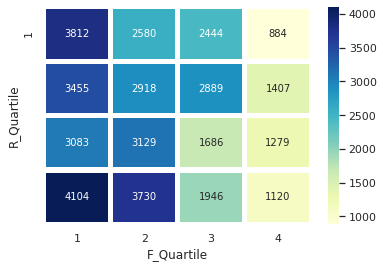

In [13]:
## Сдлеаем визуальное представление наших сегментов. 
## По графику можно понять какие пользователи часто пользуются родуктом, какие давно не пользовались, кто сколько приносит прибыли и т.д. 
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

Далее можно взять интересующие нас сегменты и придумать акции для каждого из них 